In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import copy

import sklearn
print(sklearn.__version__)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE, KMeansSMOTE, SMOTEN, SMOTENC, SVMSMOTE


1.1.1


In [2]:
path = os.getcwd()
path

'/home/fabio/tabular_lesion'

In [3]:
df = pd.read_csv('lesion_df_balanced_Target_Lesion_ClinSig.csv')
df.head()

,Inf_Train_test,Feature_lesion_P_tz_abs,Feature_lesion_P_tz_div_mean_P_tz,Feature_lesion_P_tz_sub_mean_P_tz,Feature_lesion_P_tz_std_mean_P_tz,Feature_lesion_P_tz_div_mean_P_pz,Feature_lesion_P_tz_sub_mean_P_pz,Feature_lesion_P_tz_std_mean_P_pz,Feature_lesion_P_tz_div_mean_P_prostate,Feature_lesion_P_tz_sub_mean_P_prostate,...,Feature_P_tz_Contrast_std,Feature_P_pz_Contrast_min,Feature_P_pz_Contrast_max,Feature_P_pz_Contrast_mean,Feature_P_pz_Contrast_std,Feature_P_prostate_Contrast_min,Feature_P_prostate_Contrast_max,Feature_P_prostate_Contrast_mean,Feature_P_prostate_Contrast_std,Target_Lesion_ClinSig
0,train,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,-0.429758,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
1,train,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,-0.429758,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
2,train,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,-0.429758,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
3,train,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,-0.429758,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
4,train,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,-0.429758,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1


In [4]:
df_train = df[df['Inf_Train_test'].str.contains('train', case=False)]
df_valid = df[df['Inf_Train_test'].str.contains('valid', case=False)]

training_df = pd.concat([df_train, df_valid], axis=0)
len(df_train) + len(df_valid), len(training_df)

(33764, 33764)

In [5]:
df_Clinically_Sig = pd.DataFrame(training_df.Target_Lesion_ClinSig.value_counts())
df_Clinically_Sig.reset_index(inplace=True)
df_Clinically_Sig = df_Clinically_Sig.rename(columns = {'index':'Clinically_Sig'})
df_Clinically_Sig = df_Clinically_Sig.rename(columns = {'Target_Lesion_ClinSig':'Count'})
df_Clinically_Sig

,Clinically_Sig,Count
0,0,26527
1,1,7237


In [6]:
for key in training_df.keys():
    if 'target' in key.lower():
        print(key)

Target_Lesion_ClinSig


In [7]:

fig = px.bar(df_Clinically_Sig, x='Clinically_Sig', y='Count', color=('blue', 'red'), text='Count', title='Class Balance')
fig.update_layout(showlegend=False)
fig.show(renderer="colab")

In [8]:
import xgboost as xgb

In [9]:
# import importlib
# import imblearn
# from imblearn import over_sampling as os
# for class_name in os.__all__[:6]:
#     module = importlib.import_module('imblearn.over_sampling')
#     class_ = getattr(module, class_name)
#     sampling = class_
#     print(sampling())
# os.__all__

In [10]:
df_X_train = training_df.drop(['Target_Lesion_ClinSig', 'Inf_Train_test'], axis=1)
df_y_train = training_df['Target_Lesion_ClinSig']


df_test = df[df['Inf_Train_test'].str.contains('test', case=False)]
df_X_test = df_test.drop(['Target_Lesion_ClinSig', 'Inf_Train_test'], axis=1)
df_y_test = df_test['Target_Lesion_ClinSig']

In [11]:
df_X_train.shape, df_y_train.shape, df_X_test.shape, df_y_test.shape

((33764, 132), (33764,), (4728, 132), (4728,))

In [146]:
df_X_train.isnull().values.any(), df_X_train.isnull().sum().sum()

(False, 0)

In [12]:
smote = ADASYN(random_state=2022, sampling_strategy='minority', n_jobs=4)
X_train, y_train = smote.fit_resample(df_X_train.values, df_y_train.values.ravel())

In [106]:
smote_flag = True
if smote_flag:
    X_train, y_train = smote.fit_resample(df_X_train.values, df_y_train.values.ravel())
else:
    X_train, y_train = df_X_train.values, df_y_train.values.ravel()

In [107]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [108]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights

array([1.00026388, 0.99973626])

In [110]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

autoscaler = StandardScaler()


if smote_flag:
    LR = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                           )
    LRparam_grid = {
    # 'l1_ratio': np.linspace(0.2, 0.9, num=9, retstep=True)[0],
    'C': [0.00001, 0.0001, 0.001, 0.01],
    # 'class_weight':[{0: w} for w in [0.1, 0.2, 0.3, 0.4, 0.5, 0.63640819]]
    }
else:
    LR = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            class_weight={0:0.63640819, 1:2.33273456}
                           )
    LRparam_grid = {
    # 'l1_ratio': np.linspace(0.2, 0.9, num=9, retstep=True)[0],
    'C': [0.00001, 0.0001, 0.001, 0.01],
    'class_weight':[{0: w} for w in [0.1, 0.2, 0.3, 0.4, 0.5, 0.63640819]]
    }

LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 1, cv=5)

scaled_X_train = autoscaler.fit_transform(X_train)

LR_search.fit(scaled_X_train , y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mean Accuracy: 0.862
Config: {'C': 0.001}


In [111]:
y_scores = LR_search.decision_function(autoscaler.fit_transform(df_X_test.values))

In [112]:
from sklearn.metrics import precision_recall_curve

In [113]:
from sklearn.metrics import roc_curve, auc

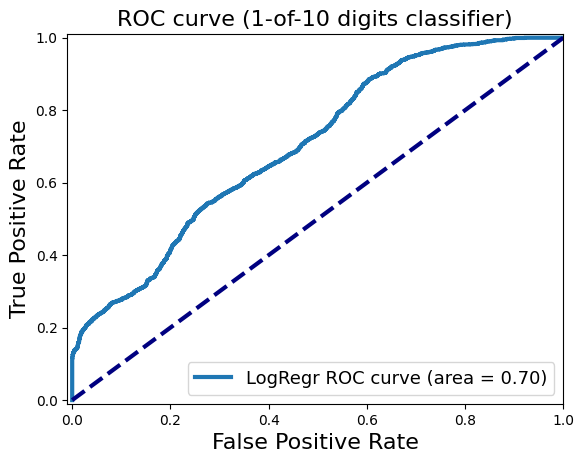

In [114]:
fpr_lr, tpr_lr, _ = roc_curve(df_y_test.values.ravel(), y_scores)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
# plt.axes().set_aspect('equal')
# plt.show()

In [115]:
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt

In [116]:
X_train_s, X_test_s, y_train_s,  y_test_s = train_test_split(scaled_X_train, y_train, test_size=0.20, random_state=2022)
X_train_s.shape, X_test_s.shape, y_train_s.shape,  y_test_s.shape

((42454, 132), (10614, 132), (42454,), (10614,))

In [117]:
if smote_flag:
    LR_best = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            C = 0.001
                           )
else:
    LR_best = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            class_weight={0:0.63640819, 1:2.33273456},
                            C = 0.001
                           )

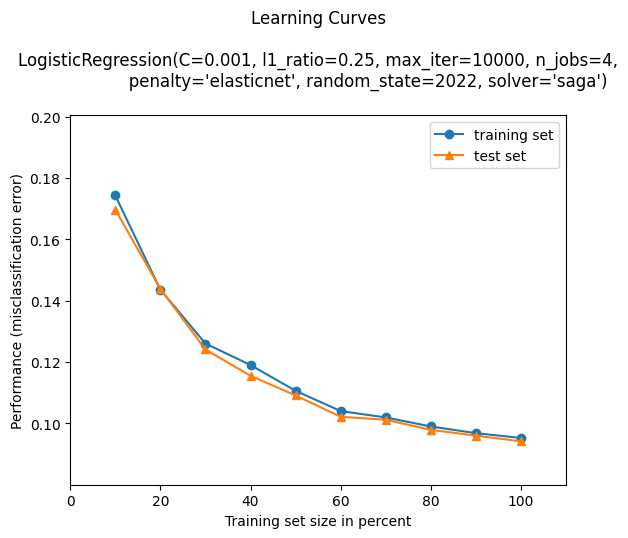

In [118]:
plot_learning_curves(X_train_s, y_train_s, X_test_s,  y_test_s, LR_best)
plt.show()

In [ ]:




# model.fit(autoscaler.fit_transform(X_train), y_train)
# get importance
importance = model.coef_[0]

In [ ]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

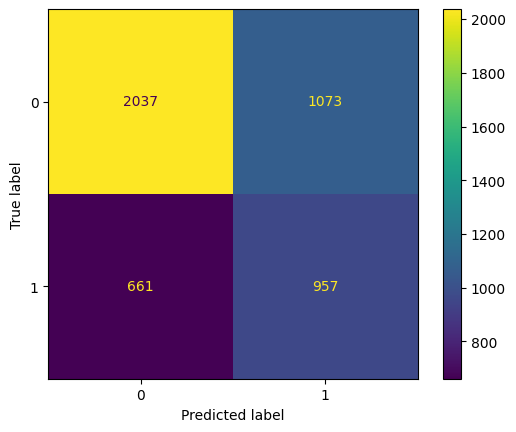

In [119]:
predictions = LR_best.predict(autoscaler.fit_transform(df_X_test.values))
cm = confusion_matrix(df_y_test.values.ravel(), predictions, labels=LR_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_best.classes_)
disp.plot()

In [120]:
val_acc = accuracy_score(df_y_test.values.ravel(), predictions)
val_f1 = f1_score(df_y_test.values.ravel(), predictions)
print(f"Acc: {val_acc} | F1: {val_f1}")

Acc: 0.633248730964467 | F1: 0.5246710526315789


In [121]:
target_names = ['class 0', 'class 1']
print(classification_report(df_y_test.values.ravel(), predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.76      0.65      0.70      3110
     class 1       0.47      0.59      0.52      1618

    accuracy                           0.63      4728
   macro avg       0.61      0.62      0.61      4728
weighted avg       0.66      0.63      0.64      4728



In [123]:
from sklearn.feature_selection import SelectFromModel

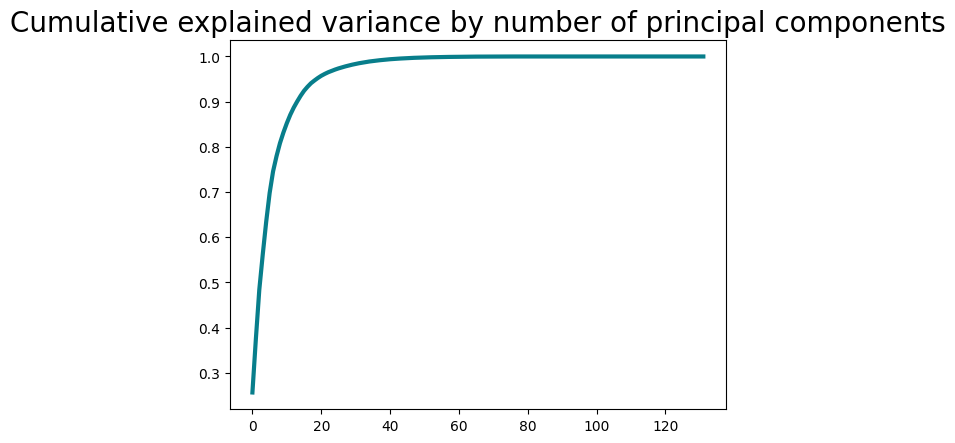

In [124]:
from sklearn.decomposition import PCA

pca = PCA().fit(scaled_X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [139]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(df_X_train.columns) + 1)],
    index=df_X_train.columns
)
loadings[0:10].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132
Feature_lesion_P_tz_abs,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,4.038151e-16,-0.000000e+00
Feature_lesion_P_tz_div_mean_P_tz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,1.675625e-17,-6.124534e-18,3.373118e-18,-1.264551e-17,-2.135140e-17,1.490095e-19,-1.959527e-17,-1.930130e-17,1.485542e-17,1.795535e-17
Feature_lesion_P_tz_sub_mean_P_tz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,-1.491828e-17,-4.769275e-19,-1.695741e-18,-6.247319e-17,3.505093e-18,1.302507e-17,-5.067165e-17,-5.686721e-17,-4.710640e-17,-1.235414e-17
Feature_lesion_P_tz_std_mean_P_tz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,-2.713736e-17,4.822052e-17,-1.536715e-17,5.905228e-17,3.232089e-17,2.054463e-17,3.610010e-17,3.543143e-17,-1.793844e-17,6.387351e-17
Feature_lesion_P_tz_div_mean_P_pz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,6.613031e-17,-4.251325e-17,1.834826e-17,7.192436e-17,-4.923234e-17,5.027064e-17,2.361233e-17,-9.982232e-18,-1.813166e-17,-1.269122e-17


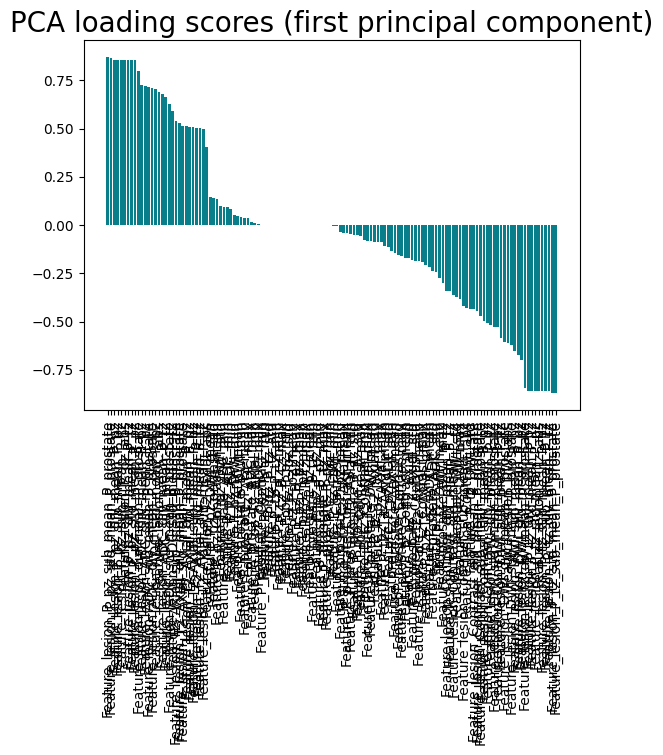

In [140]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [141]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [143]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(abs(scaled_X_train), y_train)

In [144]:
# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01
 3.817e+02 4.893e-01 5.782e+01       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan 9.949e+02
 1.876e+03 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01
 6.847e+01 1.428e+03 4.893e-01 5.782e+01       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
 9.949e+02 1.876e+03 9.664e+02 2.458e+02 6.535e+02 4.556e+02 9.954e+01
 2.746e+01 6.268e+00 2.455e+02 6.320e+01 5.821e+02 1.014e+02 9.310e+02
 9.705e+02 7.870e+02 4.504e+02 5.241e+02 4.024e+01 1.681e+02 1.430e+02
 1.069e+03 6.005e+01 9.081e+01 4.239e+02 3.819e+02 4.008e+02 2.534e+02
 3.958e+02 1.450e+02 1.656e+02 4.689e+02 3.034e+02 5.526e+02 1.779e+01
 4.043e+02 2.316e+02 5.101e+02 5.356e+02 9.181e+02 1.125e+00 5.078e+02
 6.591e+02 3.825e+02 1.471e+00 6.168e+00 3.889e+00 1.388e+00 6.194e+00
 7.494e+00 2.494e+00 7.252e+00 3.656e+01 1.324e+01 8.983e-02 6.096e+01
 6.981

In [147]:
features = fit.transform(abs(scaled_X_train))
# Summarize selected features
print(features[0:5,:])

[[0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]]


In [148]:
if smote_flag:
    LR_best = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            C = 0.001
                           )
else:
    LR_best = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            class_weight={0:0.63640819, 1:2.33273456},
                            C = 0.001
                           )

In [152]:
from sklearn.feature_selection import RFE

In [162]:
rfe = RFE(LR_best, n_features_to_select=75, step=1)

In [163]:
fit = rfe.fit(scaled_X_train, y_train)

In [164]:
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 75
Selected Features: [False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False  True  True False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
  True  True False  True  True False  True False  True  True False  True
  True False  True  True  True  True  True  True  True  True False  True
  True False  True False  True  True  True  True False  True  True False
  True  True  True False  True  True False  True False False  True  True
 False False False  True  True  True  True  True  True  True  True False]
Feature Ranking: [58 57 56 55 54 53 52  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  4  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35  1  1 38 41 40 

In [186]:
# First things first
from sklearn.linear_model import Ridge, RidgeClassifier

In [206]:
ridge = RidgeClassifier(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=10000, random_state=2022, solver='auto', tol=0.001)

In [207]:
ridge.fit(scaled_X_train, y_train)

RidgeClassifier(alpha=0.01, max_iter=10000, random_state=2022)

In [208]:
def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [209]:
# print ("Ridge model:", pretty_print_coefs(ridge.coef_))

In [210]:
# for idx, coeff in enumerate(ridge.coef_):
#     if coeff > 0.05:
#         print(idx, coeff)

In [211]:
np.std(ridge.coef_), np.mean(ridge.coef_), np.median(ridge.coef_)

(1.068076653781554, -0.012327575757865689, 0.0)

In [212]:
y_pred = ridge.predict(autoscaler.fit_transform(df_X_test.values))

In [213]:
y_pred

array([1, 1, 1, ..., 0, 0, 0])

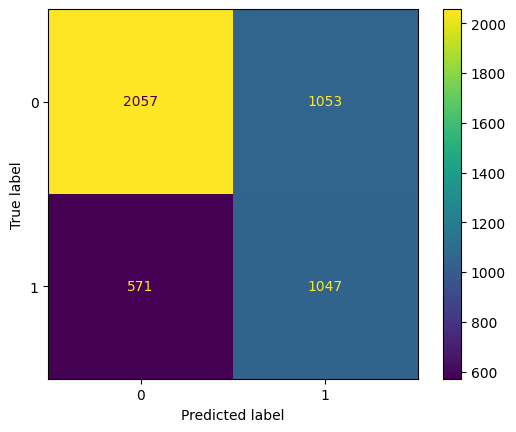

In [214]:
cm = confusion_matrix(df_y_test.values.ravel(), y_pred, labels=ridge.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge.classes_)
disp.plot()

In [215]:
target_names = ['class 0', 'class 1']
print(classification_report(df_y_test.values.ravel(), y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.78      0.66      0.72      3110
     class 1       0.50      0.65      0.56      1618

    accuracy                           0.66      4728
   macro avg       0.64      0.65      0.64      4728
weighted avg       0.69      0.66      0.66      4728



In [216]:
val_acc = accuracy_score(df_y_test.values.ravel(), y_pred)
val_f1 = f1_score(df_y_test.values.ravel(), y_pred)
print(f"Acc: {val_acc} | F1: {val_f1}")

Acc: 0.6565143824027073 | F1: 0.5632060247444862


In [122]:
# df_concat = pd.concat([df_X_train, df_y_train], axis=1)
# df_corr = df_concat.corr()

In [ ]:
threshold = 0.90


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df_concat.columns[columns]
selected_columns
df_training = df_concat[selected_columns]

In [ ]:
df_training.shape, df_concat.shape

In [ ]:
lst_diff = df_concat.columns.difference(df_training.columns)
len(lst_diff)

In [ ]:
corr_X = df_training.drop('Target_Lesion_ClinSig', axis=1)
corr_y = df_training['Target_Lesion_ClinSig']

In [ ]:
model.fit(autoscaler.fit_transform(corr_X.values), corr_y.values.ravel())
# get importance
importance = model.coef_[0]

In [ ]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
df_X_test_corr = df_X_test.drop(lst_diff, axis=1)

predictions = model.predict(autoscaler.fit_transform(df_X_test_corr.values))
cm = confusion_matrix(df_y_test.values.ravel(), predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
val_acc = accuracy_score(df_y_test.values.ravel(), predictions)
val_f1 = f1_score(df_y_test.values.ravel(), predictions)
print(f"Acc: {val_acc} | F1: {val_f1}")

In [ ]:
feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [ ]:
featfig = pyplot.figure(figsize=(12, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(corr_X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')